<a href="https://colab.research.google.com/github/amilsiddik/Deep-Learning/blob/main/Deteksi_Hand_Sign_Resnet_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2 as cv
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Penelitian/Deteksi hand sign/Dataset"
key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)

In [ ]:
df = []
for key in key_value.keys():
    for j in key_value[key]:
        df.append([key,path+'/'+key+'/'+j])
df1 = pd.DataFrame(df,columns=('label','path'))
df1

,label,path
0,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
1,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
2,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
3,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
4,6,/content/drive/MyDrive/Penelitian/Deteksi hand...
...,...,...
2057,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2058,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2059,7,/content/drive/MyDrive/Penelitian/Deteksi hand...
2060,7,/content/drive/MyDrive/Penelitian/Deteksi hand...


In [ ]:
def readimg(path):
    img= cv.imread(path)
    img = cv.resize(img,(224,224))
    return img

In [ ]:
import multiprocessing

# Create a Pool with 4 worker processes
with multiprocessing.Pool(4) as p:
    # Read in all of the images in parallel
    images = p.map(readimg, df1['path'])

In [ ]:
images=np.array(images, dtype='float')
# label encoder from sklearn
le = preprocessing.LabelEncoder()
y_labels = le.fit_transform(df1['label'])

In [ ]:
# to split the data into training and testing data
train_images,test_images,train_labels,test_labels = train_test_split(images,y_labels,test_size=0.25, random_state=42)

In [ ]:
## implementing trensfer learning
base_model = keras.applications.VGG16(weights='imagenet', include_top=False)

# freezing the base model so we donot have to train it again
base_model.trainable = False


model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='SparseCategoricalCrossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
history = model.fit(train_images,train_labels, epochs=50, batch_size=32,validation_data=(test_images, test_labels))

Epoch 1/50
49/49 [==============================] - 27s 234ms/step - loss: 0.9987 - accuracy: 0.7225 - val_loss: 0.4010 - val_accuracy: 0.8663
Epoch 2/50
49/49 [==============================] - 8s 162ms/step - loss: 0.2167 - accuracy: 0.9301 - val_loss: 0.3171 - val_accuracy: 0.8876
Epoch 3/50
49/49 [==============================] - 8s 174ms/step - loss: 0.1280 - accuracy: 0.9631 - val_loss: 0.1390 - val_accuracy: 0.9632
Epoch 4/50
49/49 [==============================] - 9s 183ms/step - loss: 0.0704 - accuracy: 0.9819 - val_loss: 0.1385 - val_accuracy: 0.9535
Epoch 5/50
49/49 [==============================] - 8s 174ms/step - loss: 0.0369 - accuracy: 0.9922 - val_loss: 0.1306 - val_accuracy: 0.9632
Epoch 6/50
49/49 [==============================] - 8s 165ms/step - loss: 0.0201 - accuracy: 0.9974 - val_loss: 0.1464 - val_accuracy: 0.9574
Epoch 7/50
49/49 [==============================] - 9s 178ms/step - loss: 0.0124 - accuracy: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.9651
Epoch

In [ ]:
from sklearn.metrics import accuracy_score

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predictions to the class labels
predicted_labels = np.argmax(predictions, axis=1)

# Compute the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)

print('Accuracy:', accuracy)

17/17 [==============================] - 2s 124ms/step
Accuracy: 0.9767441860465116


In [ ]:
from sklearn.metrics import precision_score

precision = precision_score(test_labels, predicted_labels, average='micro')

print('Precision:', precision*100)

Precision: 97.67441860465115


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

Text(0.5, 1.0, 'Accuracy Vs Epoch')

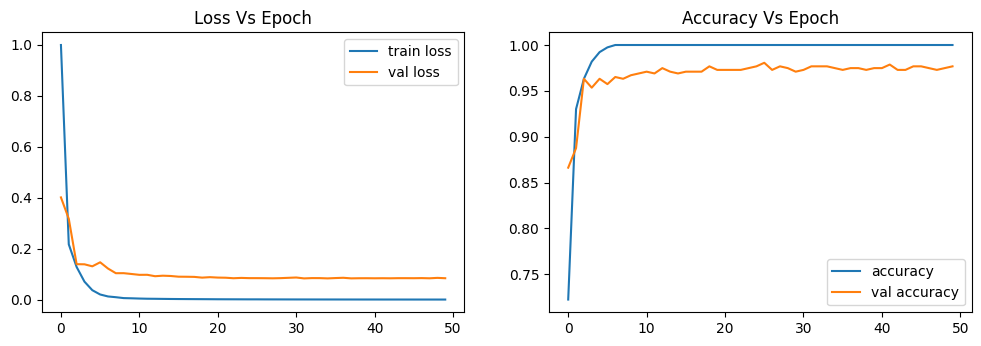

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss Vs Epoch')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title('Accuracy Vs Epoch')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 15,250,250
Trainable params: 535,562
Non-trainable params: 14,714,688
_________________________________________________________________
